In [14]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
# from utils import denoise_text, preprocess_text

from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

In [15]:
data = pd.read_csv("datasets/cards_waterloo.csv", low_memory=False)
data.sample()

,prompt,claim,PARTITION,labels,sentiment,tweetid,roberta_preprocessed,roberta_pred,roberta_proba,DATASET,...,cards_pred,cards_proba,waterloo_pred,waterloo_proba,waterloo-cards_pred,waterloo-cards_proba,roberta_new_pipe_pred,roberta_new_pipe_proba,bertweet_pred,bertweet_proba
40739,RT @YaleE360: As climate change rapidly melts ...,NaN,TRAIN,0,1.0,8.086728e+17,RT @YaleE360: As climate change rapidly melts ...,0_0,0.999204,waterloo,...,0,[9.99204935e-01 7.73551057e-05 7.82170590e-06 ...,0,[9.99992675e-01 7.32493648e-06],0,[9.99971143e-01 2.88571184e-05],0,"[0.9999876022338867, 1.2355706530797761e-05]",0,"[0.9999865293502808, 1.3520058018912096e-05]"


In [19]:
def format_scores(x):
    return np.array(eval(re.sub(",? +", " ,", str(x).replace("\n", ""))))

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
data["waterloo-cards_proba"] = data["waterloo-cards_proba"].apply(format_scores)
data["roberta_new_pipe_proba"] = data["waterloo-cards_proba"].apply(format_scores)
data["bertweet_proba"] = data["bertweet_proba"].apply(format_scores)

In [20]:
test = data[data.PARTITION=="TEST"]

## Roberta

Accuracy: 0.9395807644882861
AUC: 0.9715538215398434


,precision,recall,f1-score,support
Not Misinformation,0.954304,0.969739,0.961960,5750.000000
Misinformation,0.880495,0.827631,0.853245,1549.000000
accuracy,0.939581,0.939581,0.939581,0.939581
macro avg,0.917399,0.898685,0.907602,7299.000000
weighted avg,0.938640,0.939581,0.938888,7299.000000


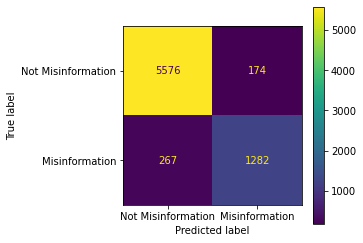

In [21]:
def report(y_true, y_pred, scores,  classes):
    
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores, multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=(4,4))
    cmp.plot(ax=ax)  
    
    return pd.DataFrame(classification_report(y_true, y_pred, target_names=classes, output_dict=True)).transpose()
    
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['roberta_new_pipe_pred'], scores, target_names)

Accuracy: 0.9635949943117179
AUC: 0.9695234081198993


,precision,recall,f1-score,support
Not Misinformation,0.979260,0.980731,0.979995,3996.000000
Misinformation,0.804071,0.791980,0.797980,399.000000
accuracy,0.963595,0.963595,0.963595,0.963595
macro avg,0.891666,0.886355,0.888987,4395.000000
weighted avg,0.963356,0.963595,0.963471,4395.000000


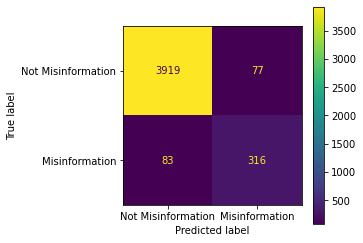

In [25]:
test_twitter = test[~test.tweetid.isna()]
scores = test_twitter['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['roberta_new_pipe_pred'], scores, target_names)

Accuracy: 0.903236914600551
AUC: 0.961584700808091


,precision,recall,f1-score,support
Not Misinformation,0.900054,0.944698,0.921836,1754.000000
Misinformation,0.908749,0.840000,0.873023,1150.000000
accuracy,0.903237,0.903237,0.903237,0.903237
macro avg,0.904402,0.892349,0.897429,2904.000000
weighted avg,0.903497,0.903237,0.902506,2904.000000


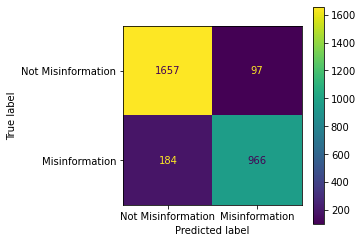

In [28]:
test_cards = test[test.tweetid.isna()]
scores = test_cards['roberta_new_pipe_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['roberta_new_pipe_pred'], scores, target_names)

## Bertweet

Accuracy: 0.935881627620222
AUC: 0.9721501670081679


,precision,recall,f1-score,support
Not Misinformation,0.950683,0.968870,0.959690,5750.000000
Misinformation,0.875608,0.813428,0.843373,1549.000000
accuracy,0.935882,0.935882,0.935882,0.935882
macro avg,0.913145,0.891149,0.901532,7299.000000
weighted avg,0.934750,0.935882,0.935005,7299.000000


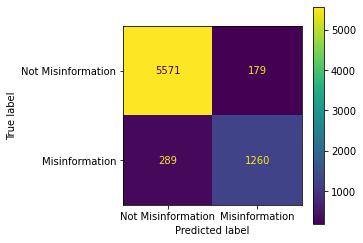

In [29]:
target_names = ["Not Misinformation", "Misinformation"]
# display(Markdown("**Waterloo-Cards**"))
scores = test['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['bertweet_pred'], scores, target_names)

Accuracy: 0.9620022753128555
AUC: 0.9724009724009725


,precision,recall,f1-score,support
Not Misinformation,0.977312,0.980981,0.979143,3996.000000
Misinformation,0.802083,0.771930,0.786718,399.000000
accuracy,0.962002,0.962002,0.962002,0.962002
macro avg,0.889698,0.876455,0.882931,4395.000000
weighted avg,0.961404,0.962002,0.961674,4395.000000


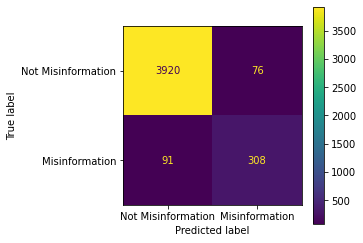

In [30]:
scores = test_twitter['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_twitter.labels, test_twitter['bertweet_pred'], scores, target_names)

Accuracy: 0.8963498622589532
AUC: 0.9585196569332208


,precision,recall,f1-score,support
Not Misinformation,0.892915,0.941277,0.916459,1754.00000
Misinformation,0.902370,0.827826,0.863492,1150.00000
accuracy,0.896350,0.896350,0.896350,0.89635
macro avg,0.897642,0.884552,0.889975,2904.00000
weighted avg,0.896659,0.896350,0.895484,2904.00000


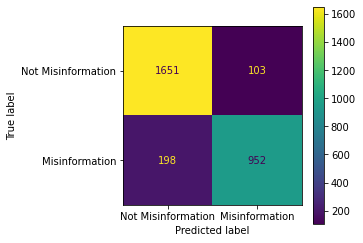

In [31]:
scores = test_cards['bertweet_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['bertweet_pred'], scores, target_names)